# Quantum generative adversarial networks

## 项目介绍

本文发表于2018年，算是比较早期的使用量子线路实现GAN模型的工作，实验采用的线路较为简单，并且通过搭建线路进行求取梯度
论文采用的线路如下：

![jupyter](./src/circuit.png)

其中，D表示判别器，G表示生成器，R表示真实数据；
out 表示输出， 对于D来说，out表示是判断输入是否为real数据的量子态，对于G和R来说，输出代表G R产生的量子态数据；
lable表示 condition GAN的标签
bath相当于GAN的随机噪声，但是在论文的数值仿真中并未启用

本文中R的分布如下，即当label为｜1〉的时候，输出也为｜1〉，当label为｜0〉的时候输出也为｜0〉，相当于一个由label控制的CNOT门，因此GAN的训练目标就是训练G使得G的输出分布接近于R的输出

D和G则有不同配置的ansatz组成，本文采用的anztza形式如下图所示

![jupyter](./src/ansatz.png)

其中D采用3qubit（q0 output， q1 label， q2 input），4 layer的anstza，共32个参数；G采用2qubit(q2 output, q3 lable), 2 layer 共10个参数；R采用一个CNOT门进行模拟

论文采用的metrics如下：

![jupyter](./src/metrics.png)

其中V_DG代表DG线路D output的Z测量，即 p_real - p_fake，在train D 和 train G的时候都会产生对应的分量；V_DR为DR线路 D output的Z测量，在实际计算中，会根据实际的线路的exception进行相应折算

S表示G和R两个分布之间的距离，即交叉熵，在实际计算时，根据mock_R mock_G的Z测量得到不同标签下G 和 R的分布，然后使用scipy中的统计工具计算交叉熵

![jupyter](./src/ce.png)

原始论文采用线路构造ansatz的梯度，因此实际实验中共用了5个qubit，q0用于求取梯度，鉴于mindquantum框架本身具备求取梯度的功能，因此复现中采用一个4qubit线路，q0 为D的输出、q1为D的label、q2为D的输入以及G、R的输出；q3为G R的输入label

论文在训练中采用的策略如下：
lr 在前4000个step从10 下降到0.1然后保持不变，共训练10000步；复现过程中发现该超参下超调较大，采用如下策略lr在8000步内由0.1 下降到0.001，共训练10000步；另外，为了保持D的稳定，论文中采用每100个step训练G一次，学习率是 train D的5倍，复现过程与论文中保持一致(PS:由于使用随机权重进行初始化，有时结果可能不理想，可以多试几次)

In [10]:
## 安装最新版Minduantum (0.5)
!pip install https://hiq.huaweicloud.com/download/mindquantum/newest/linux/mindquantum-master-cp37-cp37m-linux_x86_64.whl -i https://pypi.tuna.tsinghua.edu.cn/simple
!pip list | grep mind

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
  Using cached https://hiq.huaweicloud.com/download/mindquantum/newest/linux/mindquantum-master-cp37-cp37m-linux_x86_64.whl (624 kB)
mindquantum                  0.1.dev166
mindspore                    1.3.0
notebook-mindinsight-backend 0.0.5


## 复现过程

请调用您的代码，按照步骤对论文进行复现，并输出复现结果。

### 定义各种线路和辅助函数

In [11]:
from mindquantum import X, Y, Z, H, RX, RY, RZ, ZZ,BarrierGate
from mindquantum import Circuit, Simulator
import random
from mindquantum import QubitOperator  # 导入QubitOperator模块，用于构造泡利算符
from mindquantum import Hamiltonian  # 导入Hamiltonian模块，用于构建哈密顿量
import numpy as np
import math
import scipy.stats
from tqdm.notebook import tqdm

# anstza
def make_anstza(n_qubits, n_layers, start=0, param_frefix="theta"):
    c = Circuit()
    s = start
    for j in range(n_layers):
        tmp_c = Circuit()
        for i in range(n_qubits):
            tmp_c += RX("{}_X_l{}_n{}".format(param_frefix, j, i + s)).on(i + s)
            tmp_c += RZ("{}_Z_l{}_n{}".format(param_frefix, j, i + s)).on(i + s)
        for i in range(n_qubits // 2):
            tmp_c += ZZ(
                "{}_ZZ_l{}_n{}-n{}".format(param_frefix, j, 2 * i + s, 2 * i + 1 + s)
            ).on([2 * i + s, 2 * i + 1 + s])
        if n_qubits / 2 > 1:
            for i in range(n_qubits // 2):
                if 2 * i + 2 <= n_qubits:
                    tmp_c += ZZ(
                        "{}_ZZ_l{}_n{}-n{}".format(
                            param_frefix, j, 2 * i + 1 + s, 2 * i + 2 + s
                        )
                    ).on([2 * i + 1 + s, 2 * i + 2 + s])

        c += tmp_c
        c += BarrierGate()
    return c

# 论文中采用的R线路本质是一个cnot门
def make_R():
    return X.on(2, ctrl_qubits=3)

# D是一个4层的3qubit的anstza，共32个参数
def make_D():
    return make_anstza(n_qubits=3, n_layers=4, param_frefix="DISC")

# G是一个2层2qubit的anstza共10个参数
def make_G():
    return make_anstza(n_qubits=2, n_layers=2, param_frefix="GEN", start=2)

# 串联label R D的线路
def make_DR():
    c = Circuit()

    c += RY("lambda_D").on(1)
    c += RY("lambda_R").on(3)
    c += BarrierGate()
    c.no_grad()
    c += X.on(2, ctrl_qubits=3)
    c += BarrierGate()
    c += make_D()

#     print('DR cir ====> \n{}'.format(c))
    return c

# 串联label G D的线路，并固定G的weight的梯度，用于训练D的weight
def make_DG_train_D():
    c = Circuit()
    c += RY("lambda_D").on(1)
    c += RY("lambda_G").on(3)
    c += BarrierGate()
    c.no_grad()

    g = make_G()
    g.no_grad()
    c += g
    c += BarrierGate()

    d = make_D()
    c += d

#     print('DG_train_D cir ====> \n{}'.format(c))
    return c

# 串联label G D的线路，并固定D的weight的梯度，用于训练G的weight
def make_DG_train_G():
    c = Circuit()
    c += RY("lambda_D").on(1)
    # cook R when lambda R == 1 (q=3), out_R == 1
    c += RY("lambda_G").on(3)
    c.no_grad()
    c += BarrierGate()
    
    g = make_G()
    c += g
    c += BarrierGate()

    d = make_D()
    d.no_grad()
    c += d

#     print('DG_train_G cir ====> \n{}'.format(c))
    return c

# 构造一个线路用于抓取G的输出(q2)，输入为label lambda_G(q3)
def make_mock_G():
    c = Circuit()
    c += RY("lambda_G").on(3)
    c += BarrierGate()
    c += make_G()
    c.no_grad()
#     print('mock_G cir ====> \n{}'.format(c))
    return c

# 构造一个线路用于抓取R的输出(q2)，输入为label lambda_G(q3)
def make_mock_R():
    c = Circuit()
    c += RY("lambda_R").on(3)
    c += BarrierGate()
    c += X.on(2, ctrl_qubits=3)
    c.no_grad()
#     print('mock_R cir ====> \n{}'.format(c))
    return c

# 构造一个线路用于抓取R的输出(q0)，输入为label lambda_G(q1),以及D的input(q2)
def make_mock_D():
    c = Circuit()
    c += RY("lambda_D").on(1)
    # cook R when lambda R == 1 (q=3), out_R == 1
    c += RY("input").on(2)
    c.no_grad()
    c += BarrierGate()
    d = make_D()
    d.no_grad()
    c += d
#     print('mock D cir ====> \n{}'.format(c))
    return c

# 采样并设置标签, 线路中使用Ry(lambda) 来控制标签位的量子态，当标签为0时，lambda=0，此时Ry相当于I，即输入为|0〉
# 当标签为1时，lambda=np.pi，此时Ry相当于X，即输入为|1〉
def sample_lambda(flip_threshold=0.5):
    if random.random() > flip_threshold:
        param_dict["lambda_D"] = 0
        param_dict["lambda_G"] = 0
        param_dict["lambda_R"] = 0
        return 0
    else:
        param_dict["lambda_D"] = np.pi
        param_dict["lambda_G"] = np.pi
        param_dict["lambda_R"] = np.pi
        return 1

# 用于直接设置标签，
def set_lambda(l):
  assert l in [0, 1], "lambda must in [0, 1]"
  param_dict['lambda_D'] = l * np.pi
  param_dict['lambda_R'] = l * np.pi
  param_dict['lambda_G'] = l * np.pi

# 从全局的param_dict中获取circ对应的参数，根据需要组成字典或array
def get_params(circ, ret_dict=False):
    if ret_dict:
        return {p: param_dict[p] for p in circ.params_name}
    else:
        return np.array([param_dict.get(p, None) for p in circ.params_name]).astype(np.float32)

# 为某个circ更新参数，存储到全局变量中
def set_params(circ, new_params):
    p_dict_before = {}
    p_dict_after = {}
    for p_index, p in enumerate(circ.params_name):
        p_dict_before[p] = param_dict[p]
        param_dict[p] = new_params[p_index]
        p_dict_after[p] = param_dict[p]

### 线路展示

In [12]:
dr = make_DR()
dr

q0: ────────────────‖─────‖──RX(DISC_X_l0_n0)────RZ(DISC_Z_l0_n0)────ZZ(DISC_ZZ_l0_n0-n1)──────────────────────────‖──RX(DISC_X_l1_n0)────RZ(DISC_Z_l1_n0)────ZZ(DISC_ZZ_l1_n0-n1)──────────────────────────‖──RX(DISC_X_l2_n0)────RZ(DISC_Z_l2_n0)────ZZ(DISC_ZZ_l2_n0-n1)──────────────────────────‖──RX(DISC_X_l3_n0)────RZ(DISC_Z_l3_n0)────ZZ(DISC_ZZ_l3_n0-n1)──────────────────────────‖
                    ‖     ‖                                                   │                                    ‖                                                   │                                    ‖                                                   │                                    ‖                                                   │                                    ‖
q1: ──RY(lambda_D)──‖─────‖──RX(DISC_X_l0_n1)────RZ(DISC_Z_l0_n1)────ZZ(DISC_ZZ_l0_n0-n1)────ZZ(DISC_ZZ_l0_n1-n2)──‖──RX(DISC_X_l1_n1)────RZ(DISC_Z_l1_n1)────ZZ(DISC_ZZ_l1_n0-n1)────ZZ(DISC_ZZ_l1_n1-n2)──‖──RX(DISC_X_l2_n1)────RZ(DISC_Z_l2_n1)────ZZ(DISC_ZZ_l2_n0-n1)────ZZ(DISC_ZZ_l2_n1-n2)──‖──RX(DISC_X_l3_n1)────RZ(DISC_Z_l3_n1)────ZZ(DISC_ZZ_l3_n0-n1)────ZZ(DISC_ZZ_l3_n1-n2)──‖
                    ‖     ‖                                                                           │            ‖                                                                           │            ‖                                                                           │            ‖                                                                           │            ‖
q2: ────────────────‖──X──‖──RX(DISC_X_l0_n2)────RZ(DISC_Z_l0_n2)────────────────────────────ZZ(DISC_ZZ_l0_n1-n2)──‖──RX(DISC_X_l1_n2)────RZ(DISC_Z_l1_n2)────────────────────────────ZZ(DISC_ZZ_l1_n1-n2)──‖──RX(DISC_X_l2_n2)────RZ(DISC_Z_l2_n2)────────────────────────────ZZ(DISC_ZZ_l2_n1-n2)──‖──RX(DISC_X_l3_n2)────RZ(DISC_Z_l3_n2)────────────────────────────ZZ(DISC_ZZ_l3_n1-n2)──‖
                    ‖  │  ‖                                                                                        ‖                                                                                        ‖                                                                                        ‖                                                                                        ‖
q3: ──RY(lambda_R)──‖──●──‖────────────────────────────────────────────────────────────────────────────────────────‖────────────────────────────────────────────────────────────────────────────────────────‖────────────────────────────────────────────────────────────────────────────────────────‖────────────────────────────────────────────────────────────────────────────────────────‖

In [4]:
dg_train_d = make_DG_train_D()
dg_train_d

q0: ────────────────‖─────────────────────────────────────────────────────────────‖─────────────────────────────────────────────────────────────‖‖──RX(DISC_X_l0_n0)────RZ(DISC_Z_l0_n0)────ZZ(DISC_ZZ_l0_n0-n1)──────────────────────────‖──RX(DISC_X_l1_n0)────RZ(DISC_Z_l1_n0)────ZZ(DISC_ZZ_l1_n0-n1)──────────────────────────‖──RX(DISC_X_l2_n0)────RZ(DISC_Z_l2_n0)────ZZ(DISC_ZZ_l2_n0-n1)──────────────────────────‖──RX(DISC_X_l3_n0)────RZ(DISC_Z_l3_n0)────ZZ(DISC_ZZ_l3_n0-n1)──────────────────────────‖
                    ‖                                                             ‖                                                             ‖‖                                                   │                                    ‖                                                   │                                    ‖                                                   │                                    ‖                                                   │                                    ‖
q1: ──RY(lambda_D)──‖─────────────────────────────────────────────────────────────‖─────────────────────────────────────────────────────────────‖‖──RX(DISC_X_l0_n1)────RZ(DISC_Z_l0_n1)────ZZ(DISC_ZZ_l0_n0-n1)────ZZ(DISC_ZZ_l0_n1-n2)──‖──RX(DISC_X_l1_n1)────RZ(DISC_Z_l1_n1)────ZZ(DISC_ZZ_l1_n0-n1)────ZZ(DISC_ZZ_l1_n1-n2)──‖──RX(DISC_X_l2_n1)────RZ(DISC_Z_l2_n1)────ZZ(DISC_ZZ_l2_n0-n1)────ZZ(DISC_ZZ_l2_n1-n2)──‖──RX(DISC_X_l3_n1)────RZ(DISC_Z_l3_n1)────ZZ(DISC_ZZ_l3_n0-n1)────ZZ(DISC_ZZ_l3_n1-n2)──‖
                    ‖                                                             ‖                                                             ‖‖                                                                           │            ‖                                                                           │            ‖                                                                           │            ‖                                                                           │            ‖
q2: ────────────────‖──RX(GEN_X_l0_n2)────RZ(GEN_Z_l0_n2)────ZZ(GEN_ZZ_l0_n2-n3)──‖──RX(GEN_X_l1_n2)────RZ(GEN_Z_l1_n2)────ZZ(GEN_ZZ_l1_n2-n3)──‖‖──RX(DISC_X_l0_n2)────RZ(DISC_Z_l0_n2)────────────────────────────ZZ(DISC_ZZ_l0_n1-n2)──‖──RX(DISC_X_l1_n2)────RZ(DISC_Z_l1_n2)────────────────────────────ZZ(DISC_ZZ_l1_n1-n2)──‖──RX(DISC_X_l2_n2)────RZ(DISC_Z_l2_n2)────────────────────────────ZZ(DISC_ZZ_l2_n1-n2)──‖──RX(DISC_X_l3_n2)────RZ(DISC_Z_l3_n2)────────────────────────────ZZ(DISC_ZZ_l3_n1-n2)──‖
                    ‖                                                 │           ‖                                                 │           ‖‖                                                                                        ‖                                                                                        ‖                                                                                        ‖                                                                                        ‖
q3: ──RY(lambda_G)──‖──RX(GEN_X_l0_n3)────RZ(GEN_Z_l0_n3)────ZZ(GEN_ZZ_l0_n2-n3)──‖──RX(GEN_X_l1_n3)────RZ(GEN_Z_l1_n3)────ZZ(GEN_ZZ_l1_n2-n3)──‖‖────────────────────────────────────────────────────────────────────────────────────────‖────────────────────────────────────────────────────────────────────────────────────────‖────────────────────────────────────────────────────────────────────────────────────────‖────────────────────────────────────────────────────────────────────────────────────────‖

In [5]:
dg_train_g = make_DG_train_G()
dg_train_g

q0: ────────────────‖─────────────────────────────────────────────────────────────‖─────────────────────────────────────────────────────────────‖‖──RX(DISC_X_l0_n0)────RZ(DISC_Z_l0_n0)────ZZ(DISC_ZZ_l0_n0-n1)──────────────────────────‖──RX(DISC_X_l1_n0)────RZ(DISC_Z_l1_n0)────ZZ(DISC_ZZ_l1_n0-n1)──────────────────────────‖──RX(DISC_X_l2_n0)────RZ(DISC_Z_l2_n0)────ZZ(DISC_ZZ_l2_n0-n1)──────────────────────────‖──RX(DISC_X_l3_n0)────RZ(DISC_Z_l3_n0)────ZZ(DISC_ZZ_l3_n0-n1)──────────────────────────‖
                    ‖                                                             ‖                                                             ‖‖                                                   │                                    ‖                                                   │                                    ‖                                                   │                                    ‖                                                   │                                    ‖
q1: ──RY(lambda_D)──‖─────────────────────────────────────────────────────────────‖─────────────────────────────────────────────────────────────‖‖──RX(DISC_X_l0_n1)────RZ(DISC_Z_l0_n1)────ZZ(DISC_ZZ_l0_n0-n1)────ZZ(DISC_ZZ_l0_n1-n2)──‖──RX(DISC_X_l1_n1)────RZ(DISC_Z_l1_n1)────ZZ(DISC_ZZ_l1_n0-n1)────ZZ(DISC_ZZ_l1_n1-n2)──‖──RX(DISC_X_l2_n1)────RZ(DISC_Z_l2_n1)────ZZ(DISC_ZZ_l2_n0-n1)────ZZ(DISC_ZZ_l2_n1-n2)──‖──RX(DISC_X_l3_n1)────RZ(DISC_Z_l3_n1)────ZZ(DISC_ZZ_l3_n0-n1)────ZZ(DISC_ZZ_l3_n1-n2)──‖
                    ‖                                                             ‖                                                             ‖‖                                                                           │            ‖                                                                           │            ‖                                                                           │            ‖                                                                           │            ‖
q2: ────────────────‖──RX(GEN_X_l0_n2)────RZ(GEN_Z_l0_n2)────ZZ(GEN_ZZ_l0_n2-n3)──‖──RX(GEN_X_l1_n2)────RZ(GEN_Z_l1_n2)────ZZ(GEN_ZZ_l1_n2-n3)──‖‖──RX(DISC_X_l0_n2)────RZ(DISC_Z_l0_n2)────────────────────────────ZZ(DISC_ZZ_l0_n1-n2)──‖──RX(DISC_X_l1_n2)────RZ(DISC_Z_l1_n2)────────────────────────────ZZ(DISC_ZZ_l1_n1-n2)──‖──RX(DISC_X_l2_n2)────RZ(DISC_Z_l2_n2)────────────────────────────ZZ(DISC_ZZ_l2_n1-n2)──‖──RX(DISC_X_l3_n2)────RZ(DISC_Z_l3_n2)────────────────────────────ZZ(DISC_ZZ_l3_n1-n2)──‖
                    ‖                                                 │           ‖                                                 │           ‖‖                                                                                        ‖                                                                                        ‖                                                                                        ‖                                                                                        ‖
q3: ──RY(lambda_G)──‖──RX(GEN_X_l0_n3)────RZ(GEN_Z_l0_n3)────ZZ(GEN_ZZ_l0_n2-n3)──‖──RX(GEN_X_l1_n3)────RZ(GEN_Z_l1_n3)────ZZ(GEN_ZZ_l1_n2-n3)──‖‖────────────────────────────────────────────────────────────────────────────────────────‖────────────────────────────────────────────────────────────────────────────────────────‖────────────────────────────────────────────────────────────────────────────────────────‖────────────────────────────────────────────────────────────────────────────────────────‖

In [6]:
mock_g = make_mock_G()
mock_g

q2: ────────────────‖──RX(GEN_X_l0_n2)────RZ(GEN_Z_l0_n2)────ZZ(GEN_ZZ_l0_n2-n3)──‖──RX(GEN_X_l1_n2)────RZ(GEN_Z_l1_n2)────ZZ(GEN_ZZ_l1_n2-n3)──‖
                    ‖                                                 │           ‖                                                 │           ‖
q3: ──RY(lambda_G)──‖──RX(GEN_X_l0_n3)────RZ(GEN_Z_l0_n3)────ZZ(GEN_ZZ_l0_n2-n3)──‖──RX(GEN_X_l1_n3)────RZ(GEN_Z_l1_n3)────ZZ(GEN_ZZ_l1_n2-n3)──‖

In [7]:
mock_r = make_mock_R()
mock_r

q2: ────────────────‖──X──
                    ‖  │
q3: ──RY(lambda_R)──‖──●──

In [8]:
mock_d = make_mock_D()
mock_d

q0: ────────────────‖──RX(DISC_X_l0_n0)────RZ(DISC_Z_l0_n0)────ZZ(DISC_ZZ_l0_n0-n1)──────────────────────────‖──RX(DISC_X_l1_n0)────RZ(DISC_Z_l1_n0)────ZZ(DISC_ZZ_l1_n0-n1)──────────────────────────‖──RX(DISC_X_l2_n0)────RZ(DISC_Z_l2_n0)────ZZ(DISC_ZZ_l2_n0-n1)──────────────────────────‖──RX(DISC_X_l3_n0)────RZ(DISC_Z_l3_n0)────ZZ(DISC_ZZ_l3_n0-n1)──────────────────────────‖
                    ‖                                                   │                                    ‖                                                   │                                    ‖                                                   │                                    ‖                                                   │                                    ‖
q1: ──RY(lambda_D)──‖──RX(DISC_X_l0_n1)────RZ(DISC_Z_l0_n1)────ZZ(DISC_ZZ_l0_n0-n1)────ZZ(DISC_ZZ_l0_n1-n2)──‖──RX(DISC_X_l1_n1)────RZ(DISC_Z_l1_n1)────ZZ(DISC_ZZ_l1_n0-n1)────ZZ(DISC_ZZ_l1_n1-n2)──‖──RX(DISC_X_l2_n1)────RZ(DISC_Z_l2_n1)────ZZ(DISC_ZZ_l2_n0-n1)────ZZ(DISC_ZZ_l2_n1-n2)──‖──RX(DISC_X_l3_n1)────RZ(DISC_Z_l3_n1)────ZZ(DISC_ZZ_l3_n0-n1)────ZZ(DISC_ZZ_l3_n1-n2)──‖
                    ‖                                                                           │            ‖                                                                           │            ‖                                                                           │            ‖                                                                           │            ‖
q2: ───RY(input)────‖──RX(DISC_X_l0_n2)────RZ(DISC_Z_l0_n2)────────────────────────────ZZ(DISC_ZZ_l0_n1-n2)──‖──RX(DISC_X_l1_n2)────RZ(DISC_Z_l1_n2)────────────────────────────ZZ(DISC_ZZ_l1_n1-n2)──‖──RX(DISC_X_l2_n2)────RZ(DISC_Z_l2_n2)────────────────────────────ZZ(DISC_ZZ_l2_n1-n2)──‖──RX(DISC_X_l3_n2)────RZ(DISC_Z_l3_n2)────────────────────────────ZZ(DISC_ZZ_l3_n1-n2)──‖

## 建立线路并初始化权重

In [13]:
## ver. 1

# 建立各种线路
dr = make_DR()
dg_train_d = make_DG_train_D()
dg_train_g = make_DG_train_G()
mock_g = make_mock_G()
mock_r = make_mock_R()
mock_d = make_mock_D()


# 设置初始值 随机初始化
# 全局共享参数 ===> param_dict
lambda_init = 0
d_param_init = 2 * np.pi
g_param_init = 2 * np.pi

param_dict = {}
param_list = list(
    set(dr.params_name + dg_train_d.params_name + dg_train_g.params_name)
)


for p in param_list:
    if "lambda" in p:
        param_dict[p] = lambda_init 
    if "DISC" in p:
        param_dict[p] = d_param_init * random.random()
    if "GEN" in p:
        param_dict[p] = g_param_init * random.random()

print(param_dict)


# 生成一个基于projectq后端的模拟器，并设置模拟器的比特数为量子线路的比特数。
sim = Simulator("projectq", 4)

# dr线路输出，进行Z测量，D输入为R的输出，得到结果 相当于D判断R输出为real的概率减去 fake的概率， 梯度为d的权重梯度，训练d时候希望D判断R输入为real的概率越大越好
grad_func_dr = sim.get_expectation_with_grad(
    Hamiltonian(QubitOperator(f"Z0")), #p_real - p_fake
    dr, ansatz_params_name=dr.params_name
)

# dg线路输出，进行-Z测量，得到结果 相当于D判断 g fake的概率减去 real的概率， 梯度为d的权重梯度，训练d时候希望D判断G输入为fake的概率越大越好
grad_func_dg_train_d = sim.get_expectation_with_grad(
    Hamiltonian(QubitOperator(f"Z0", -1)), #p_fake - p_real #p_real - p_fake
    dg_train_d, ansatz_params_name=dg_train_d.params_name
)

# dg线路输出，进行Z测量，得到结果 相当于D判断 g real的概率减去 fake的概率， 梯度为g的权重梯度，训练g时候希望D判断G输入为real的概率越大越好
grad_func_dg_train_g = sim.get_expectation_with_grad(
    Hamiltonian(QubitOperator(f"Z0")), #p_real - p_fake
    dg_train_g, ansatz_params_name=dg_train_g.params_name
)

# 用于测量g的输出，获取g的输出概率分布
grad_func_mock_g = sim.get_expectation_with_grad(
    Hamiltonian(QubitOperator(f"Z2")), #p0 - p1，用于获取 generator output的概率分布
    mock_g, ansatz_params_name=mock_g.params_name
)

# 用于测量r的输出，获取g的输出概率分布
grad_func_mock_r = sim.get_expectation_with_grad(
    Hamiltonian(QubitOperator(f"Z2")), #p0 - p1，用于获取 R output的概率分布
    mock_r, ansatz_params_name=mock_r.params_name
)

{'GEN_X_l0_n2': 3.780328038372047, 'DISC_X_l1_n1': 1.8609894830356406, 'DISC_X_l2_n1': 4.984235205101651, 'DISC_ZZ_l1_n1-n2': 1.3768662218161227, 'DISC_Z_l3_n1': 4.711552751507918, 'DISC_X_l2_n2': 5.687602079186553, 'lambda_R': 0, 'DISC_ZZ_l3_n1-n2': 4.901579992504204, 'GEN_Z_l1_n2': 1.2044893932878187, 'DISC_X_l0_n2': 3.9400201034506304, 'GEN_Z_l0_n2': 4.967955818759237, 'GEN_ZZ_l0_n2-n3': 1.3764882313205131, 'DISC_ZZ_l3_n0-n1': 0.12649338983624317, 'DISC_X_l0_n1': 3.416077084766586, 'lambda_G': 0, 'DISC_Z_l3_n2': 2.3208669983637153, 'DISC_X_l2_n0': 0.6794248904128621, 'DISC_ZZ_l2_n1-n2': 5.180926648994995, 'DISC_Z_l1_n2': 5.523122265412385, 'DISC_Z_l1_n1': 2.504380065764558, 'DISC_Z_l1_n0': 0.8790410152375415, 'GEN_Z_l1_n3': 1.6196589594011632, 'DISC_Z_l3_n0': 0.5051485395755628, 'DISC_X_l1_n0': 5.249843918943382, 'DISC_Z_l2_n2': 1.3104492146674758, 'DISC_Z_l2_n0': 0.3162377515934218, 'DISC_X_l3_n0': 6.012819306947698, 'lambda_D': 0, 'GEN_X_l1_n2': 2.3285953573641134, 'DISC_ZZ_l0_n1-

### 训练(基础方式)
采用论文方案，未使用高级优化方法

In [14]:
# 存储各个metrics
v_dr_list = []
v_dg_train_d_list = []
v_dg_train_g_list = []
V_DR_list = []
V_DG_list = []
V_list = []
ce_list = [[],[]]
lr_list = []

# 学习率 在8000步之内 从0.1 下降到0.001
lr_init = 1e-1
lr_end = 1e-3
drop_step = 8000
train_step = 30000


# lr_init = 1e-1
# lr_end = 5e-3
# drop_step = 4000
# train_step = 10000


# lr_init = 10
# lr_end = 0.1
# drop_step = 10000
# train_step = 50000

pbar = tqdm(["A", "B", "C", "D", "E", "F"])

for k in  tqdm(range(train_step)):

    if k < drop_step:
        lr = lr_init - k*(lr_init-lr_end)/drop_step
    else:
        lr = lr_end
        
    lr_list.append(lr)
    
    # 随机采样并设置label
    lam = sample_lambda()

    # 使用DR线路训练D
    dr_params = get_params(dr)
    v_dr, g_dr = grad_func_dr(dr_params)
    v_dr = float(v_dr[0][0])
    g_dr = np.array(g_dr).astype(np.float32)[0][0]
    v_dr_list.append(v_dr)
    dr_params += 1 * lr * g_dr * (1-v_dr)
    set_params(dr, dr_params)
    
    # 使用DG线路训练D
    dg_train_d_params = get_params(dg_train_d)
    v_dg_train_d, g_dg_train_d = grad_func_dg_train_d(dg_train_d_params)
    v_dg_train_d = float(v_dg_train_d[0][0])
    v_dg_train_d_list.append(v_dg_train_d)
    g_dg_train_d = np.array(g_dg_train_d).astype(np.float32)[0][0]
    dg_train_d_params += 0.5 * lr * g_dg_train_d * (1-v_dg_train_d)
    set_params(dg_train_d, dg_train_d_params)

    # 使用DG线路训练G 每100步训练一次
    dg_train_g_params = get_params(dg_train_g)
    v_dg_train_g, g_dg_train_g = grad_func_dg_train_g(dg_train_g_params)
    v_dg_train_g = float(v_dg_train_g[0][0])
    v_dg_train_g_list.append(v_dg_train_g)
    g_dg_train_g = np.array(g_dg_train_g).astype(np.float32)[0][0]
    if (k % 100) == 0:
        dg_train_g_params += 5*lr * g_dg_train_g * (1-v_dg_train_g)
        set_params(dg_train_g, dg_train_g_params)

    # calculate metrics
    # 将线路的Exception转换为论文的metric
    V_DR = (v_dr - v_dg_train_d)/2 * 1/4
    V_DR_list.append(V_DR)
    V_DG = -1/4 * v_dg_train_g
    V_DG_list.append(V_DG)
    V = 0.5 + V_DR + V_DG
    V_list.append(V)
    
    # 测量G输出的分布，不同label下的分布保存在不同的list里
    mock_g_params = get_params(mock_g)
    v_mock_g, g_mock_g = grad_func_mock_g(mock_g_params)
    v_mock_g = float(v_mock_g[0][0])
    p0_g = (1 + v_mock_g)/2
    p1_g = 1 - p0_g
    
    # 测量R输出的分布，不同label下的分布保存在不同的list里
    mock_r_params = get_params(mock_r)
    v_mock_r, g_mock_r = grad_func_mock_r(mock_r_params)
    v_mock_r = float(v_mock_r[0][0])
    p0_r = (1 + v_mock_r)/2
    p1_r = 1 - p0_r
    
    # 计算R输出与G输出分布的距离（交叉熵）
    ce = scipy.stats.entropy(np.array([(1 + v_mock_r)/2, (1 - v_mock_r)/2]), np.array([(1 + v_mock_g)/2, (1 - v_mock_g)/2]))
    ce_list[lam].append(ce)
    
    pbar.set_description("lr={:.2e}, label={}, V_DG={:.2f}, V_DR={:.2f}, V={:.2f}, ce={:.2e}".format(lr, lam, V_DG, V_DR, V, ce))


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

/home/ma-user/anaconda3/envs/MindQuantum/lib/python3.7/site-packages/ipykernel/__main__.py:46: ComplexWarning: Casting complex values to real discards the imaginary part
/home/ma-user/anaconda3/envs/MindQuantum/lib/python3.7/site-packages/ipykernel/__main__.py:47: ComplexWarning: Casting complex values to real discards the imaginary part
/home/ma-user/anaconda3/envs/MindQuantum/lib/python3.7/site-packages/ipykernel/__main__.py:55: ComplexWarning: Casting complex values to real discards the imaginary part
/home/ma-user/anaconda3/envs/MindQuantum/lib/python3.7/site-packages/ipykernel/__main__.py:57: ComplexWarning: Casting complex values to real discards the imaginary part
/home/ma-user/anaconda3/envs/MindQuantum/lib/python3.7/site-packages/ipykernel/__main__.py:64: ComplexWarning: Casting complex values to real discards the imaginary part
/home/ma-user/anaconda3/envs/MindQuantum/lib/python3.7/site-packages/ipykernel/__main__.py:66: ComplexWarning: Casting complex values to real discards

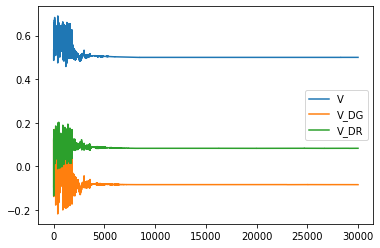

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

# 绘制metrics曲线
plt.plot(range(len(V_list)), V_list, label='V')
plt.plot(range(len(V_DG_list)), V_DG_list, label='V_DG')
plt.plot(range(len(V_DR_list)), V_DR_list, label='V_DR')
plt.legend()

Text(0.5, 1.0, 'Cross entropy between R||G (lambda=0,1)')

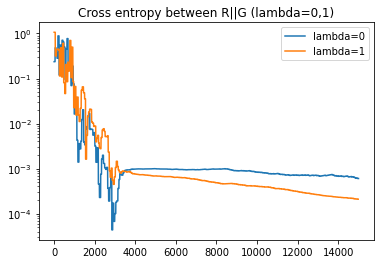

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

# 绘制交叉熵对数曲线
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.plot(range(len(ce_list[0])), ce_list[0], label='lambda=0')
ax.plot(range(len(ce_list[1])), ce_list[1], label='lambda=1')
ax.legend()
ax.set_yscale('log')
ax.set_title('Cross entropy between R||G (lambda=0,1)')

Text(0.5, 1.0, 'learning rate')

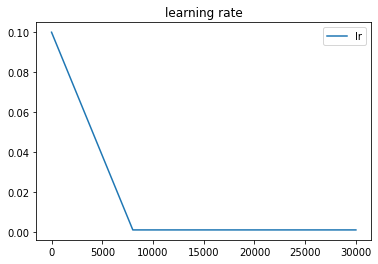

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

# 绘制学习率曲线
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(range(len(lr_list)), lr_list, label='lr')
ax.legend()
ax.set_title('learning rate')

In [18]:
# 测量R线路的输出
def test_R(label):

    assert label in [0, 1]
    tmp_r = make_mock_R()

    lam = label* np.pi
    # lam = 0

    qs = tmp_r.get_qs(pr={'lambda_R': lam}, ket=True)
    print(qs)

    h = Hamiltonian(QubitOperator(f"Z2"))

    grad_func_tmp_r = sim.get_expectation_with_grad(
        h, tmp_r, ansatz_params_name=tmp_r.params_name
    )
    v_tmp_r, g = grad_func_tmp_r(np.array([lam]).astype(np.float32))
    print(v_tmp_r)
    v_tmp_r = float(v_tmp_r[0][0])
    print('v_tmp_r ===> {} p ====> ({}, {})(label = {})'.format(v_tmp_r, (1+v_tmp_r)/2, (1-v_tmp_r)/2,  label))


test_R(0)
test_R(1)

1¦0000⟩
[[1.+0.j]]
v_tmp_r ===> 1.0 p ====> (1.0, 0.0)(label = 0)
1¦1100⟩
[[-1.+0.j]]
v_tmp_r ===> -0.9999999999999961 p ====> (1.942890293094024e-15, 0.999999999999998)(label = 1)


/home/ma-user/anaconda3/envs/MindQuantum/lib/python3.7/site-packages/ipykernel/__main__.py:20: ComplexWarning: Casting complex values to real discards the imaginary part


In [19]:
# 测量G线路的输出
def test_G(label):

    assert label in [0, 1]

    tmp_g = make_mock_G()

    tmp_g_params = []
    tmp_g_params_dict = {}
    
    for i, p in enumerate(tmp_g.params_name):
        if 'lambda' in p:
            # print('origin p {} ===> {}'.format(p, mock_g_params))
            tmp_g_params.append(label * np.pi)
            tmp_g_params_dict[p] = label * np.pi
        else:
            tmp_g_params.append(param_dict[p])
            tmp_g_params_dict[p] = param_dict[p]

    grad_func_tmp_g = sim.get_expectation_with_grad(
        Hamiltonian(QubitOperator(f"Z2")), 
        tmp_g, ansatz_params_name=tmp_g.params_name
    )

    v_mock_g, g_mock_g = grad_func_tmp_g(np.array(tmp_g_params).astype(np.float32))
    v_mock_g = float(v_mock_g[0][0])
    p0_g = (1 + v_mock_g)/2
    p1_g = 1 - p0_g
    print('p_g ===> ({},{}) (label = {})'.format(p0_g, p1_g, label))


test_G(label = 0)
test_G(label = 1)

p_g ===> (0.9993993607544209,0.000600639245579071) (label = 0)
p_g ===> (0.00020902626667806956,0.9997909737333219) (label = 1)


/home/ma-user/anaconda3/envs/MindQuantum/lib/python3.7/site-packages/ipykernel/__main__.py:26: ComplexWarning: Casting complex values to real discards the imaginary part


In [15]:
# 测量D的输出
def test_D(label, input):

    assert label in [0, 1]

    tmp_d = make_mock_D()

    tmp_d_params = []
    tmp_d_params_dict = {}
    
    for i, p in enumerate(tmp_d.params_name):
        if 'lambda' in p:
            tmp_d_params.append(label * np.pi)
            tmp_d_params_dict[p] = label * np.pi
        elif 'input' in p:
            tmp_d_params.append(input * np.pi)
            tmp_d_params_dict[p] = input * np.pi
        else:
            tmp_d_params.append(param_dict[p])
            tmp_d_params_dict[p] = param_dict[p]

    grad_func_tmp_d = sim.get_expectation_with_grad(
        Hamiltonian(QubitOperator(f"Z0")), 
        tmp_d, ansatz_params_name=tmp_d.params_name
    )

    v_mock_d, g_mock_d = grad_func_tmp_d(np.array(tmp_d_params).astype(np.float32))
    v_mock_d = float(v_mock_d[0][0])
    p0_d = (1 + v_mock_d)/2
    p1_d = 1 - p0_d
    print('p_d ===> ({},{}) (label = {}, input= {})'.format(p0_d, p1_d, label, input))


test_D(label = 0, input = 0)

p_d ===> (0.6659937462625751,0.3340062537374249) (label = 0, input= 0)


/home/ma-user/anaconda3/envs/MindQuantum/lib/python3.7/site-packages/ipykernel/__main__.py:28: ComplexWarning: Casting complex values to real discards the imaginary part


In [1]:
# 收敛的初值

# param_dict.update(
#     {
#       'DR-D_Z_l0_n2': 3.839108863476723,
#       'DR-D_ZZ_l0_n0-n1': 4.777260028759172,
#       'DR-D_X_l0_n0': 5.790653672801085,
#       'DR-D_X_l1_n2': 4.890289986080045,
#       'DR-D_ZZ_l2_n0-n1': 5.739603064515961,
#       'DR-D_X_l2_n0': 1.0622928776914426,
#       'DG-G_X_l0_n2': 0.23961352872866656,
#       'DR-D_ZZ_l1_n1-n2': 0.7326745718525026,
#       'DR-D_X_l3_n2': 0.19023035643583988,
#       'DR-D_X_l2_n1': 4.376391199922374,
#       'DR-D_X_l3_n1': 0.8331217111239116,
#       'DR-D_Z_l0_n0': 2.7374576515788767,
#       'DR-D_ZZ_l0_n1-n2': 0.18680116892150825,
#       'DR-D_X_l0_n1': 1.107365031155365,
#       'DR-D_Z_l0_n1': 3.8475077450988198,
#       'DG-G_ZZ_l0_n2-n3': 4.626278973874565,
#       'DG-G_Z_l0_n3': 5.233679738889154,
#       'DR-D_Z_l3_n0': 5.257309098897445,
#       'lambda_G': 0,
#       'DG-G_Z_l0_n2': 3.6901782069736337,
#       'DG-G_Z_l1_n2': 6.114840851308679,
#       'DR-D_ZZ_l2_n1-n2': 3.4441601272304774,
#       'DR-D_Z_l2_n0': 4.1220713730380565,
#       'lambda_R': 0,
#       'DR-D_ZZ_l3_n0-n1': 0.4136008984580062,
#       'DG-G_ZZ_l1_n2-n3': 6.010561286165329,
#       'DG-G_Z_l1_n3': 4.089015451178149,
#       'DR-D_X_l2_n2': 2.3793163326699953,
#       'DR-D_X_l1_n1': 0.98156640874781,
#       'DR-D_Z_l1_n2': 4.773696444918468,
#       'DR-D_X_l1_n0': 3.367023332046047,
#       'DR-D_Z_l1_n0': 3.3623392330320554,
#       'DR-D_ZZ_l1_n0-n1': 2.5830706556550065,
#       'DG-G_X_l0_n3': 2.65806760184436,
#       'DG-G_X_l1_n2': 4.947521272506985,
#       'DG-G_X_l1_n3': 2.338147020258475,
#       'DR-D_Z_l2_n1': 6.236779678437334,
#       'DR-D_Z_l2_n2': 2.5656517742562426,
#       'DR-D_Z_l3_n1': 0.4094698589426494,
#       'DR-D_Z_l3_n2': 1.5156094633401316,
#       'DR-D_X_l3_n0': 5.540799479601808,
#       'DR-D_ZZ_l3_n1-n2': 5.4300962237492065,
#       'DR-D_X_l0_n2': 3.4658732927244045,
#       'DR-D_Z_l1_n1': 1.0172347949810838,
#       'lambda_D': 0
#   }
# )

# {'lambda_D': 0, 'DR-D_X_l2_n1': 5.2845332133032095, 'DR-D_Z_l3_n1': 1.9047805336708727, 'DR-D_X_l1_n1': 2.7125911282490383, 'DR-D_X_l3_n1': 5.466778597288312, 'DG-G_Z_l1_n2': 3.313785311344431, 'DR-D_Z_l2_n1': 4.008536070967694, 'DG-G_Z_l1_n3': 4.855070590498995, 'DR-D_Z_l2_n0': 5.372092010743951, 'lambda_R': 0, 'DR-D_Z_l1_n2': 5.294164525681635, 'DR-D_X_l1_n0': 2.7706844294581856, 'DR-D_ZZ_l3_n0-n1': 5.88834940041474, 'DG-G_X_l1_n2': 6.0733718486038, 'DR-D_Z_l1_n1': 0.08421528279279435, 'DG-G_X_l1_n3': 2.6181364679741947, 'DR-D_X_l1_n2': 3.1760320991579034, 'DR-D_X_l0_n1': 0.7917300767290806, 'DR-D_X_l3_n0': 0.15227041190188423, 'DR-D_Z_l0_n0': 5.923912101261675, 'DG-G_X_l0_n2': 5.105686736267702, 'DG-G_ZZ_l1_n2-n3': 1.1858811394453812, 'DR-D_ZZ_l0_n1-n2': 1.086745172416222, 'DR-D_X_l2_n2': 3.1236225751760385, 'DR-D_Z_l1_n0': 5.971895019927827, 'DR-D_Z_l2_n2': 3.5714417233226174, 'DR-D_ZZ_l2_n0-n1': 0.3844559411788957, 'DR-D_Z_l3_n2': 5.28983657440638, 'DR-D_X_l0_n0': 4.00373911426721, 'DR-D_Z_l0_n2': 3.9629689132499446, 'DR-D_ZZ_l1_n1-n2': 2.801659902437118, 'DG-G_ZZ_l0_n2-n3': 0.31376308694679494, 'lambda_G': 0, 'DR-D_ZZ_l2_n1-n2': 3.733324131213021, 'DG-G_Z_l0_n3': 2.239504291574241, 'DR-D_ZZ_l0_n0-n1': 3.2554197912901923, 'DR-D_ZZ_l1_n0-n1': 0.9781647730568624, 'DR-D_Z_l0_n1': 2.1014923776994543, 'DR-D_X_l0_n2': 2.797322699125935, 'DR-D_X_l3_n2': 4.795231927723021, 'DG-G_Z_l0_n2': 1.6163059670788018, 'DR-D_X_l2_n0': 4.715220980079688, 'DR-D_Z_l3_n0': 2.0893715183660984, 'DR-D_ZZ_l3_n1-n2': 4.776326635667237, 'DG-G_X_l0_n3': 2.298702426772755}


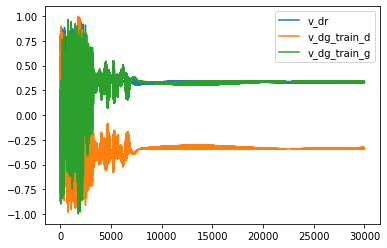

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt


# lines = plt.plot(range(len(v_dr_list)), v_dr_list)

plt.plot(range(len(v_dr_list)), v_dr_list, label='v_dr')
plt.plot(range(len(v_dg_train_d_list)), v_dg_train_d_list, label='v_dg_train_d')
plt.plot(range(len(v_dg_train_g_list)), v_dg_train_g_list, label='v_dg_train_g')
plt.legend()

## 项目总结

总结：

 1. 可以使用量子线路实现简单的condition GAN 
 2. 使用论文中的anstza通过训练可以使得G逼近R的CNOT线路 
 3. 使用mindquantum框架可以避免原论文中通过搭建线路求取grad的方法，有效简化模型实现难度

未来研究方向：

 1. 目前在GAN上，量子计算并没有体现出优势来，而且仅能进行简单问题的模拟，未来期望使用QuGAN处理较为复杂的GAN任务，包括漫画脸，超分等等，对比其与传统计算模式的优势；
 2. 使用mindspore的MQLayer及成熟的优化方法进行权重学习
 3. 尝试使用其他anstza进行训练
